In [4]:
import torch
import numpy as np
import pandas as pd
import json
from ipywidgets import interact, FloatSlider, Button, HBox, VBox, HTML, Layout, Output
from joblib import load
from modules.cGAN_samplers import noise_sampler
from modules.functions import decode, calculate_entropy_mixing
from modules.plotting import Radar
import matplotlib.pyplot as plt

In [2]:
model = torch.jit.load('saved_cGAN/generator.pt',map_location='cpu')
with open('saved_cGAN/gan_hyperparameters.json','r') as fid:
    gan_hyperparameters = json.load(fid)
selected_props = gan_hyperparameters['selected_props']
latent_dim = gan_hyperparameters['latent_dim']
prop_dim = gan_hyperparameters['prop_dim']
elem_list = gan_hyperparameters['elem_list']

scaler_pipe = load('saved_cGAN/scale_kde_pipe.joblib')

In [3]:
def generate_alloy(prop_arr):
    input_data = np.array(prop_arr).reshape(1,-1).astype('float32')
    scaled_input = torch.from_numpy(scaler_pipe['Scaler'].transform(input_data))
    noise = torch.from_numpy(noise_sampler(1,latent_dim))
    with torch.no_grad():
        generated = model(noise,scaled_input)
    composition = decode(generated[0], elem_list)
    res = np.zeros((1,len(selected_props)))
    for i,prop in enumerate(selected_props):
        if prop == 'delta_S':
            res[:,0] = calculate_entropy_mixing(composition)
        else:
            model_surrogate = load(f'saved_surrogates/surrogate_{prop}.joblib')
            res[:,i] = model_surrogate.predict(generated.numpy())

    print(f'Generated composition with given conditions : {composition}')
    print(pd.DataFrame(res, columns=selected_props))


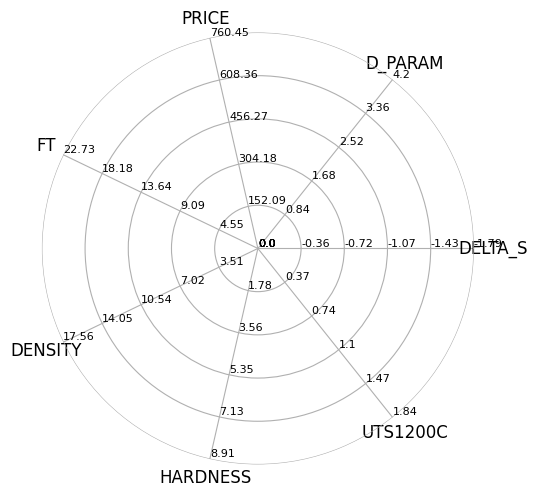

In [38]:
demo_df = pd.read_csv('dataset/demo_dataset_true.csv',index_col=0)
dict_of_props = {}

for p in selected_props:
    vals = demo_df.loc[:,p].values
    dict_of_props[p.lower()] = {'min':np.round(np.min(vals),2),
                        'max':np.round(np.max(vals),2),
                        'value':np.round((np.min(vals)+np.max(vals))/2,2),
                        'step':0.01,
                        'description':p.upper()
                        }
    
out = Output()
with out:
        fig = plt.figure()

tit = [x.upper() for x in selected_props]
labels = []
steps = []
for p in dict_of_props.keys():
        if p!='delta_s':
            linsp, step = np.linspace(0,dict_of_props[p]['max'],6, retstep=True)
        else:
            linsp, step = np.linspace(0,dict_of_props[p]['min'],6, retstep=True)
        labels.append(np.round(linsp,2))
        steps.append(step)
radar= Radar(fig, tit, labels)


list_of_sliders = [FloatSlider(**params) for params in dict_of_props.values()]

reset_button = Button(
    description='Reset',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Reset the slider values'
)

generate_button = Button(
    description='Generate',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Generate HEA composition with selected conditions'
)


def reset(_):
    for slider in list_of_sliders:
        slider.value = dict_of_props[slider.description.lower()]['value']

    

# Importing required modules
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Function for plotting figures
def plot_function(_):
    # Update the three slider variables based on user input
    arr = np.zeros(len(list_of_sliders))
    for i,sl in enumerate(list_of_sliders):
        arr[i] = sl.value
    # Create the figure
    r_new = []
    for i,p in enumerate(dict_of_props.keys()):
        if p!='delta_s':
            r_new.append(np.round((arr[i]/dict_of_props[p]['max']*5),2))
        else:
            r_new.append(np.round((arr[i]/dict_of_props[p]['min']*5),2))
    radar.plot(r_new)
    fig.canvas.draw()
   

# Create the three sliders with range and default values specified

# Create a button widget
reset_button.on_click(reset)
generate_button.on_click(plot_function)

# Connect the event handler to the "on_click" event of the button

# Display all the widgets 

controls = widgets.VBox([*list_of_sliders, generate_button,reset_button])
widgets.HBox([controls, out])

In [39]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))

def update(w = 1.0):
    line.set_ydata(np.sin(w * x))
    fig.canvas.draw()

interact(update)

<IPython.core.display.Javascript object>

interactive(children=(FloatSlider(value=1.0, description='w', max=3.0, min=-1.0), Output()), _dom_classes=('wi…

<function __main__.update(w=1.0)>